In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("HW_4_pinball.ipynb")

# HWK 4 pinball simulation

The full pinball simulation: slides https://docs.google.com/presentation/d/1fNTOc_4YXfBkQ_ko9X8eQqAgK3Opnn9c02i72sVDqKU/edit?usp=sharing

Full pinball 
 - position and velocity with Euler simulation (lecture activity, compute_next_step)
 - stop when ball passes below y=0 (lab, simulate_pinball version 1)
 - "Bouncing" off of the top and side walls (lab, outside_xx_wall, handle bounce, simulate_pinball version 1)
 - "Bouncing" off of bumpers (homework)

Week 1: 
- Circular "bumpers" OR a wall at an angle (circular bumpers add extra credit)
- [optional] Some bumpers will impart an acceleration to the pinball
- [optional] Add damping

Week 2: Some simple calculations
- Length of path pinball travels
- Integral of vx and vy


In [2]:
# The usual imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# These commands will force JN to actually re-load the external file when you re-execute the import command
%load_ext autoreload
%autoreload 2

<!-- BEGIN QUESTION -->

## Circular bumper or angled wall: How to implement?

TODO: Write code to handle a circular bumper OR an angled wall

- decide which functions/what the format of the functions should be written to handle a bumper or angled wall
- decide how you will represent a bumper or an angled wall

Note: You'll add tests and simulation and plotting in the following questions

This is a manually graded question

**TODO:** 

Use this cell to describe how you are implementing your bumper or angled wall routines
- How are you representing the bumper/angled wall?
- What functions are you creating and why? What are the function inputs and outputs?


In [4]:
# Imports from week 5
# This bit of code tells Jupyter notebooks to also look in the week_6_optimization folder for files
import os
import sys

# If you want them...
sys.path.insert(0, os.path.abspath('../Week_5_matrices'))

In [5]:
# TODO: Write additional routines here
# You can write them here or put them in pinball_routines.py and import them here
# Add one cell for each function
def crossed_angled(prev_pos, cur_pos, a_b_c):
    a, b, c = a_b_c
    f_prev = a*prev_pos[0]+b*prev_pos[1]+c
    f_cur = a*cur_pos[0]+b*cur_pos[1]+c
    return f_prev*f_cur < 0

def reflect_angled(state, a_b_c, radius=0.0):
    a, b, c = a_b_c

    wall_normal = np.array([a, b], dtype=float)
    norm_len = np.linalg.norm(wall_normal)
    if norm_len < 1e-12:
        return state
    wall_normal /= norm_len

    pos = state[0]
    vel = state[1]

    dist = np.dot(pos, wall_normal) + c
    if dist < 0.0:
        wall_normal = -wall_normal
        dist = -dist

    v_dot_n = np.dot(vel, wall_normal)
    if v_dot_n < 0.0:
        vel = vel - 2.0 * v_dot_n * wall_normal
        state[1] = vel

    if dist < radius:
        correction = (radius - dist) * wall_normal
        pos += correction
        state[0] = pos

    return state



In [6]:
# TODO: Add tests here to test your functions
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Simulation routine

TODO: Copy over the simulation routine from your lab

- Change the function's parameters so that they take in the bumpers/angled wall as well
- Optional: If you implement acceleration or drag then describe it here 

This question is manually graded. Describe what you did, why, and how

TODO: Describe your solution here

In [7]:
# Pinball_routines imports
from pinball_routines import acceleration_due_to_gravity, compute_next_step, outside_top_wall, outside_left_wall, outside_right_wall

In [8]:
# Simulate pinball routine
#. TODO Copy your lab solution here
#       Change the parameters to support your circular bumpers or angled wall
def simulate_pinball(starting_state, top_wall=5, left_wall=-3, right_wall=3, delta_t=0.1, angled_wall=None):
    """ Call compute one time step multiple times and store it in a numpy array
    @param starting_state - the starting positino, velocity, acceleration
    @param delta_t - the time step to use. Define a default t value that you've determined works well
    @return position values as a 2xtimesteps numpy array
    """

    # The returned array.We do not know the size, so do not pre-allocate
    ret_pose_all = []
    ret_vels = []

    # TODO (question 1) Use a while loop instead of the for loop
    # Set the stopping criteria based on current state y value
    current_state = starting_state
    ret_pose_all.append(current_state[0, :])
    ret_vels.append(current_state[1, :])
    prev_position = current_state[0, :].copy()

    while current_state[0, 1] >= 0:
        current_state = compute_next_step(current_state, delta_t)

    # TODO (question 2)
    # Add in each wall/top at a time (there are test routines for reach below)
    # Use if statements, not if-else statements, because it is possible to be outside of the top and side wall...
        if current_state[0, 1] > top_wall:
            current_state[1, 1] = -current_state[1, 1]
            current_state[0, 1] = top_wall

        if current_state[0, 0] < left_wall:
            current_state[1, 0] = -current_state[1, 0]
            current_state[0, 0] = left_wall

        if current_state[0, 0] > right_wall:
            current_state[1, 0] = -current_state[1, 0]
            current_state[0, 0] = right_wall

        if angled_wall is not None:
             if crossed_angled(prev_position, current_state[0], angled_wall):
                current_state = reflect_angled(current_state, angled_wall)
                
        prev_position = current_state[0, :].copy()
        ret_pose_all.append(current_state[0, :])
        ret_vels.append(current_state[1, :])
    # All done - return the numpy array
    #  Why does this look like this? Because when you do the append you've made a very long
    # list of lists with 2 elements (x,y) in them. When you give this list to numpy to convert
    # into an array it will make an n x 2 numpy array for you. So if you want it back in
    # our format from the lecture activity, you need to do what's called a transpose, which
    # swaps the rows and columns, and gives you a 2 x n array instead.

    return np.array(ret_pose_all).transpose(), np.array(ret_vels).transpose()

In [9]:
# Time step
delta_t = 0.01

# Test 1 - do you stop when you hit the floor?
starting_state = np.zeros([3, 2])  # location, velocity, acceleration
starting_state[0, :] = [0, 0] # Start at zero, zero
starting_state[1, :] = [2.4, 8.5]
starting_state[2, :] = [0.0, acceleration_due_to_gravity()]

# Define your bumper/angled wall here
# Default is top wall at y=5, left/right walls at +- 3.0
angled_wall = [-5, 2, 5]

top_wall = 5.0
left_wall = -3.0
right_wall = 3.0



In [10]:
# Test the simulate_pinball function, with at least setup
ret_poses = simulate_pinball(starting_state, top_wall=top_wall, left_wall=left_wall, right_wall=right_wall, delta_t=0.1, angled_wall=angled_wall)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Plot bumpers or angled wall, walls, and path

TODO: Start with the plotting code from the lab
 - add plotting the bumpers or angled wall
 - pass the data structure you use to define the bumpers and walls to the plot routine
 
TODO: Generate at least 2 plots showing the pinball doing different behaviors (must include reflection off of wall, bumper[s]/angled wall)

This question is manually graded

In [11]:
# TODO: Create a function to plot the pinball track, walls, and bumpers
#  Start with the lab plot
# Plot the walls and the pinball path
def plot_pinball_lab(axs, ret_poses, walls, angled_wall, total_time):
    """ plot the results of running the system AND the "correct" closed form result
    @param ret_poses - x y position values in a 2xn numpy array
    @param walls - The walls and ceiling locations (top, left, right)
    @param total_time - the total time the system ran (for closed form solution, delta_t * n time steps)
    @return Nothing
    """
    # The values we calculated in calculate_n_time_steps
    axs.plot([walls[1], walls[2]], [walls[0], walls[0]], '-m', label=f"Top wall {top_wall}")
    axs.plot([walls[1], walls[2]], [0, 0], '-k', label="Floor wall")
    axs.plot([walls[1], walls[1]], [0, walls[0]], '-g', label="Left wall")
    axs.plot([walls[2], walls[2]], [0, walls[0]], '-g', label="Right wall")

    if angled_wall is not None:
        a, b, c = angled_wall
        x_vals = np.linspace(walls[1] -1, walls[2] +1, 500)
        y_vals = (-a * x_vals -c) / b
        y_vals2 = np.clip(y_vals, 0, walls[0])
        axs.plot(x_vals, y_vals2, '-r', label='Angled Wall')

    axs.plot(ret_poses[0, 0], ret_poses[1, 0], 'xr', label="Start")
    axs.plot(ret_poses[0, :], ret_poses[1, :], '.-k', label="Poses")

    axs.axis('equal')
    axs.set_title(f"Boring pinball, 0-{total_time} s")
    axs.legend()

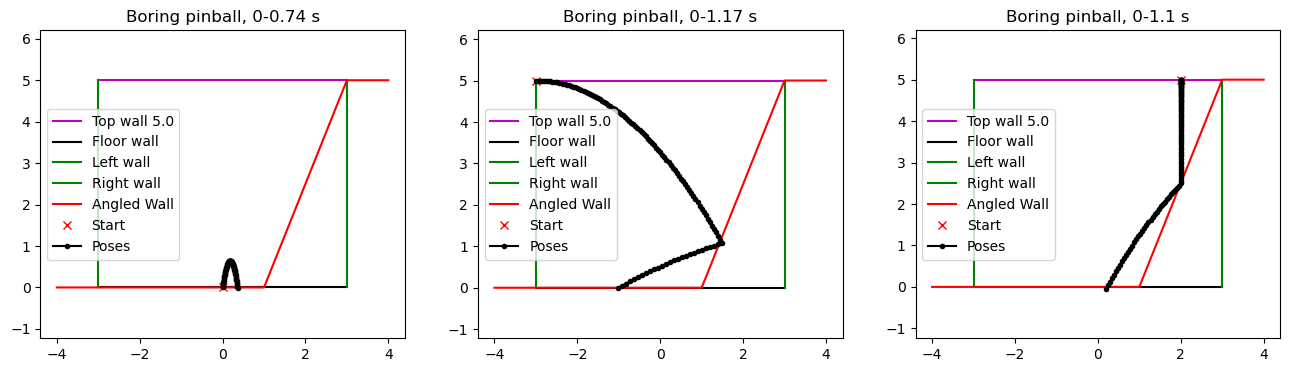

In [26]:
# TODO: set up different starting positions and/or pinball setups and plot them
nrows = 1
ncols = 3
_, axs = plt.subplots(nrows, ncols, figsize=(16, 4))

ret_poses = simulate_pinball(starting_state, top_wall=top_wall, left_wall=left_wall, right_wall=right_wall, delta_t=0.01, angled_wall=angled_wall)
total_time = delta_t * ret_poses[0].shape[1]
plot_pinball_lab(axs[0], ret_poses[0], [top_wall, left_wall, right_wall], angled_wall, total_time)

starting_state_new = np.array([[-3, 5], [5.0, 0.0], [0.0, acceleration_due_to_gravity()]])

ret_poses = simulate_pinball(starting_state=starting_state_new, top_wall=top_wall, left_wall=left_wall, right_wall=right_wall, delta_t=0.01, angled_wall=angled_wall)
total_time = delta_t * ret_poses[0].shape[1]
plot_pinball_lab(axs[1], ret_poses[0], [top_wall, left_wall, right_wall], angled_wall, total_time)

starting_state_newer = np.array([[2, 5], [0.0, 0.0], [0.0, acceleration_due_to_gravity()]])

ret_poses = simulate_pinball(starting_state=starting_state_newer, top_wall=top_wall, left_wall=left_wall, right_wall=right_wall, delta_t=0.01, angled_wall=angled_wall)
total_time = delta_t * ret_poses[0].shape[1]
plot_pinball_lab(axs[2], ret_poses[0], [top_wall, left_wall, right_wall], angled_wall, total_time)

In [13]:
# Manual grade
print("This is a manually-graded question; there is no grader.check() function. See rubric and slides for more information on expected output.")

This is a manually-graded question; there is no grader.check() function. See rubric and slides for more information on expected output.


<!-- END QUESTION -->

## Week 2 - Use integration to calculate length of path

TODO: Calculate the length of the pinball path using euclidian distances

In [14]:
def length_of_pinball_path(poses):
    """ Calculate the length of the pinball path using euclidian distances
    @param poses - the x,y poses
    @return length"""
    # TODO: Sum up the distance between all of the pose points
    # Reminder: Distance is sqrt(x^2 + y^2)
    diffs = np.diff(poses, axis=1)
    dist = np.sqrt(diffs[0]**2 + diffs[1]**2)
    total = np.sum(dist)
    return total

In [15]:
# TODO For these tests use this starting state
#  - do NOT place a bumper/wall in the path - it should just go up and down
#  - Use the given starting position and velocity
#  - Use a delta t of 0.01
#  - Do NOT do damping
starting_state = np.zeros([3, 2])  # location, velocity, acceleration
starting_state[0, :] = [0, 0] # Start at zero, zero
# Velocity - mostly up with a bit of x noise
starting_state[1, :] = [0.5, 3.5]
starting_state[2, :] = [0.0, acceleration_due_to_gravity()]

# TODO: call your simulate routine with  delta_t = 0.01 and the above starting state

ret_poses = simulate_pinball(starting_state, top_wall=top_wall, left_wall=left_wall, right_wall=right_wall, delta_t=0.01)


In [16]:
# poses check - 
len_path = (length_of_pinball_path(ret_poses[0]))
print(f"Distance traveled {len_path}, expected 1.386298")

Distance traveled 1.3862984861585559, expected 1.386298


In [17]:
grader.check("integrate_path")

integrate_path results: All test cases passed!

## Integrate x velocity and y velocity

TODO: Calculate the total relative distance the pinball traveled in x and y by integrating the velocity in x and y
- TODO: Change your simulation code so it returns velocities in addition to poses
- Call trapz with the vx values, using a fixed dx (delta_t) (this is the integral)

In [18]:
# EXAMPLE CODE
# To return the velocities in addition to the poses you want to
#   1) replicate your code for storing the positions, only this time, store the velocities
#   2) return the velocities as well as the positions
#   3) extract the velocities out

# There's two ways to do this, either as a 4xn array (get the velocities out afterwards, or two 2xn arrays)
n = 10
ret_vals = np.zeros((4, n))  # storing x, y, vx, vy in each column
x = 0
y = 0
vx = 0.1
vy = 0.2
state = np.zeros((2, 2))
state[0, :] = [x, y]    # First row is position
state[1, :] = [vx, vy]  # Second row is velocity
for i in range(0, n):
    ret_vals[0:2, i] = state[0, :]   # put the current state position in the first two rows
    ret_vals[2:4, i] = state[1, :]   # put the current state position in the 3rd and fourth rows

    # Increment state
    state[0, :] = state[0, :] + state[1, :] * 0.1
# return ret_vals
    
# Calling function
poses = ret_vals[0:2, :]
vels = ret_vals[2:4, :]

# OR
ret_poses = np.zeros((2, n))  # storing x, y in each column
ret_vels = np.zeros((2, n))  # storing vx, vy in each column
x = 0
y = 0
vx = 0.1
vy = 0.2
state = np.zeros((2, 2))
state[0, :] = [x, y]    # First row is position
state[1, :] = [vx, vy]  # Second row is velocity
for i in range(0, n):
    ret_poses[0:2, i] = state[0, :]   # put the current state position in the first two rows
    ret_vels[0:2, i] = state[1, :]   # put the current state position in the 3rd and fourth rows

    # Increment state
    state[0, :] = state[0, :] + state[1, :] * 0.1

# return ret_poses, ret_vels
# poses, vels = func()


In [19]:
def integral_of_path_velocity(velocities, delta_t):
    """ Calculate the x and y distance traveled of the pinball path by integrating the velocities
    @param velocities - the vx,vy velocities at each time step
    @param delta_t - the sampling used to generate the velocities
    @return integral of vx, integral of vy"""
    # TODO: Calculate the integral of vx and vy
    # Note: You'll want trapz because these are samples of the velocity function
    integral_x = np.trapz(velocities[0, :], dx=delta_t)
    integral_y = np.trapz(velocities[1, :], dx=delta_t)
    return integral_x, integral_y

In [20]:
# This needs to be a 2xn array of the velocities at each time step
ret_velocities = (simulate_pinball(starting_state, top_wall=top_wall, left_wall=left_wall, right_wall=right_wall, delta_t=0.01))[1]

# Note - make sure you're using the starting state given in the path integration
integral_x, integral_y = integral_of_path_velocity(ret_velocities, delta_t)
print(f"Integral of x velocity {integral_x}, expected 0.365")
print(f"Integral of y velocity {integral_y}, expected -0.056209")

Integral of x velocity 0.365, expected 0.365
Integral of y velocity -0.05620999999999904, expected -0.056209


In [21]:
grader.check("integrate_velocity")

integrate_velocity results: All test cases passed!

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [22]:

# List of names (creates a set)
worked_with_names = {"N/A"}
# List of URLS I25 (creates a set)
websites = {"https://numpy.org/"}
# Approximate number of hours, including lab/in-class time
hours = 5

In [23]:
grader.check("hours_collaborators")

hours_collaborators results: All test cases passed!

### To submit

Double check your plots. Don't forget **pinball_routines.py**. We will include **matrix_routines.py**; but it won't hurt if you include it as well.

- Submit this .ipynb file  and pinball_routines.py to homework 4 (pinball)

If the Gradescope autograder fails, please check here first for common reasons for it to fail
    https://docs.google.com/presentation/d/1tYa5oycUiG4YhXUq5vHvPOpWJ4k_xUPp2rUNIL7Q9RI/edit?usp=sharing

Congratulations, and enjoy being done with this class for the term!